# Function Testing Notebook - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
import logging
import os
import sys
import tempfile
import time
from pathlib import Path

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster

import matplotlib as mpl
import seaborn as sns
import seaborn.objects as so
from okabeito import black, blue, green, lightblue, orange, purple, red, yellow
from seaborn import axes_style


In [2]:
from pythoneeg import constants, core, visualization

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tempdir = Path('../../tmp').resolve()
print(tempdir)
core.set_temp_directory(tempdir)

/mnt/isilon/marsh_single_unit/PythonEEG/tmp


In [4]:
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.WARNING, stream=sys.stdout, force=True)
logger = logging.getLogger()

In [5]:
# df = pd.read_pickle("/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/examples/alphadelta_avg_delta_alpha.pkl")
# df = pd.read_pickle("/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/examples/alphadelta_avg_delta_alpha_minimally_filtered.pkl")
df = pd.read_pickle("/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/examples/alphadelta_avg_delta_alpha_rms.pkl")
df

,animal,genotype,total_minutes,alphadelta,delta,alpha,rms
0,#2 Cage 2A_e9cc873a6d6b79a86397c077563b19b6561...,MMut,0.0,0.234007,8.247529,6.740746,4.676993
1,#2 Cage 2A_e9cc873a6d6b79a86397c077563b19b6561...,MMut,60.0,0.228662,8.425400,6.879663,4.719508
2,#2 Cage 2A_e9cc873a6d6b79a86397c077563b19b6561...,MMut,120.0,0.269835,8.016271,6.679470,4.708600
3,#2 Cage 2A_e9cc873a6d6b79a86397c077563b19b6561...,MMut,180.0,0.252214,8.150257,6.728984,4.699226
4,#2 Cage 2A_e9cc873a6d6b79a86397c077563b19b6561...,MMut,240.0,0.221260,8.419399,6.845646,4.718865
...,...,...,...,...,...,...,...
1460,mouse M5 cage4A_4a4982335dc33d4430a1b4808dc0ef...,MMut,1140.0,0.216192,7.352728,5.733307,4.293633
1461,mouse M5 cage4A_4a4982335dc33d4430a1b4808dc0ef...,MMut,1200.0,0.215719,7.415463,5.745764,4.285264
1462,mouse M5 cage4A_4a4982335dc33d4430a1b4808dc0ef...,MMut,1260.0,0.224275,7.519125,5.892567,4.380513
1463,mouse M5 cage4A_4a4982335dc33d4430a1b4808dc0ef...,MMut,1320.0,0.238181,7.265817,5.707692,4.518880


In [6]:
df = df.reset_index(drop=False)
df["sex"] = df["genotype"].str[0]
df["sex"] = df["sex"].map({"F": "Female", "M": "Male"})
df["genotype"] = df["genotype"].str[1:]
df['total_minutes'] = (df['total_minutes'] - 6 * 60) % 1440
for feature in ['alphadelta', 'delta', 'alpha', 'rms']:
    df[f"{feature}_nobase"] = (
        df.groupby(["animal", "genotype", "sex"])
        .apply(lambda g: g[feature] - g.loc[(g["total_minutes"] <= 12 * 60), feature].mean())
        .reset_index(level=[0, 1, 2], drop=True)
    )
# Create a copy of df with shifted total_minutes
df2 = df.copy()
df2['total_minutes'] = df2['total_minutes'] + 1440

# Concatenate original and shifted dataframes
df = pd.concat([df, df2], ignore_index=True)

df

/tmp/ipykernel_3406345/64246500.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[feature] - g.loc[(g["total_minutes"] <= 12 * 60), feature].mean())
/tmp/ipykernel_3406345/64246500.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[feature] - g.loc[(g["total_minutes"] <= 12 * 60), feature].mean())
/tmp/ipykernel_3406345/64246500.py:9: FutureWarning: DataFrameGroupBy.apply oper

,index,animal,genotype,total_minutes,alphadelta,delta,alpha,rms,sex,alphadelta_nobase,delta_nobase,alpha_nobase,rms_nobase
0,0,#2 Cage 2A_e9cc873a6d6b79a86397c077563b19b6561...,Mut,1080.0,0.234007,8.247529,6.740746,4.676993,Male,0.011124,-0.006869,0.047331,0.007462
1,1,#2 Cage 2A_e9cc873a6d6b79a86397c077563b19b6561...,Mut,1140.0,0.228662,8.425400,6.879663,4.719508,Male,0.005780,0.171001,0.186248,0.049976
2,2,#2 Cage 2A_e9cc873a6d6b79a86397c077563b19b6561...,Mut,1200.0,0.269835,8.016271,6.679470,4.708600,Male,0.046952,-0.238128,-0.013944,0.039068
3,3,#2 Cage 2A_e9cc873a6d6b79a86397c077563b19b6561...,Mut,1260.0,0.252214,8.150257,6.728984,4.699226,Male,0.029331,-0.104142,0.035569,0.029695
4,4,#2 Cage 2A_e9cc873a6d6b79a86397c077563b19b6561...,Mut,1320.0,0.221260,8.419399,6.845646,4.718865,Male,-0.001622,0.165000,0.152231,0.049334
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,1460,mouse M5 cage4A_4a4982335dc33d4430a1b4808dc0ef...,Mut,2220.0,0.216192,7.352728,5.733307,4.293633,Male,-0.057963,0.310440,0.074557,-0.138558
2926,1461,mouse M5 cage4A_4a4982335dc33d4430a1b4808dc0ef...,Mut,2280.0,0.215719,7.415463,5.745764,4.285264,Male,-0.058435,0.373176,0.087013,-0.146927
2927,1462,mouse M5 cage4A_4a4982335dc33d4430a1b4808dc0ef...,Mut,2340.0,0.224275,7.519125,5.892567,4.380513,Male,-0.049879,0.476837,0.233817,-0.051677
2928,1463,mouse M5 cage4A_4a4982335dc33d4430a1b4808dc0ef...,Mut,2400.0,0.238181,7.265817,5.707692,4.518880,Male,-0.035973,0.223529,0.048942,0.086689


In [7]:
# Get stats for number of unique animals by genotype and sex
animal_counts = df.groupby(['genotype', 'sex'])['animal'].nunique()
print("\nNumber of unique animals by genotype and sex:")
print(animal_counts)
print("\nTotal number of unique animals:", df['animal'].nunique())



Number of unique animals by genotype and sex:
genotype  sex   
Het       Female    13
          Male      10
Mut       Female    10
          Male      13
WT        Female     6
          Male      13
Name: animal, dtype: int64

Total number of unique animals: 65


/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


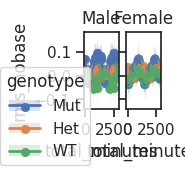

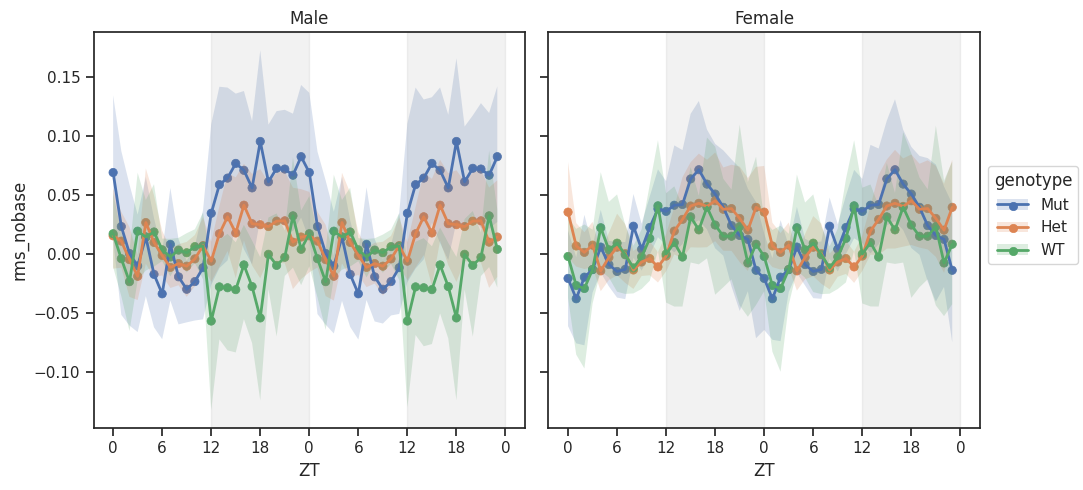

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


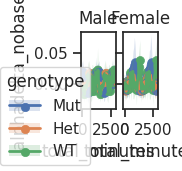

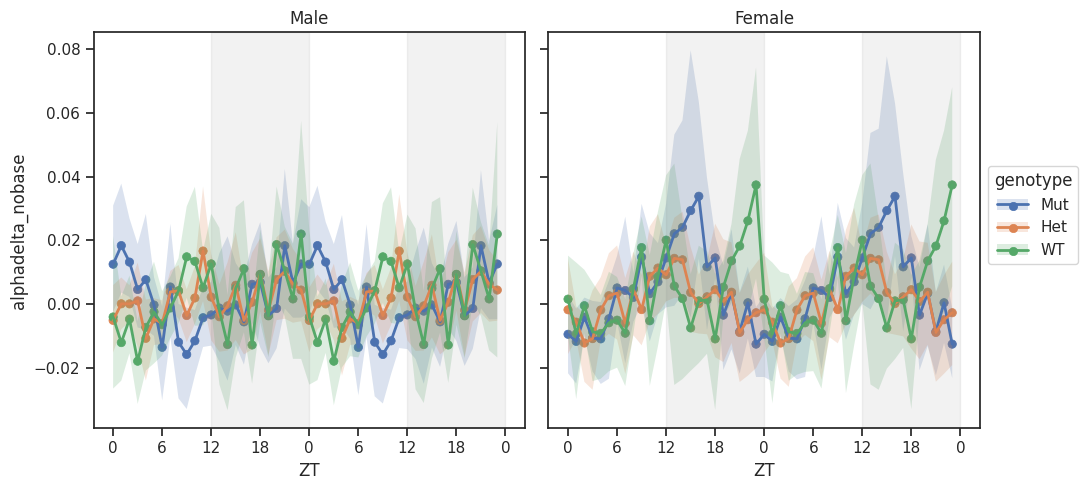

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


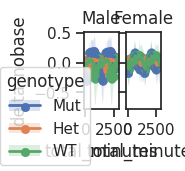

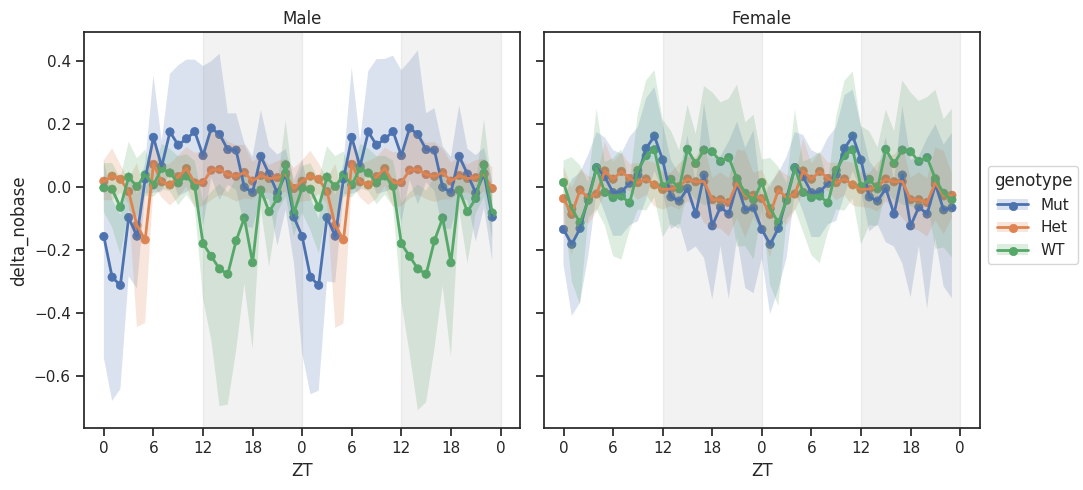

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


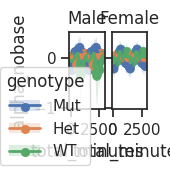

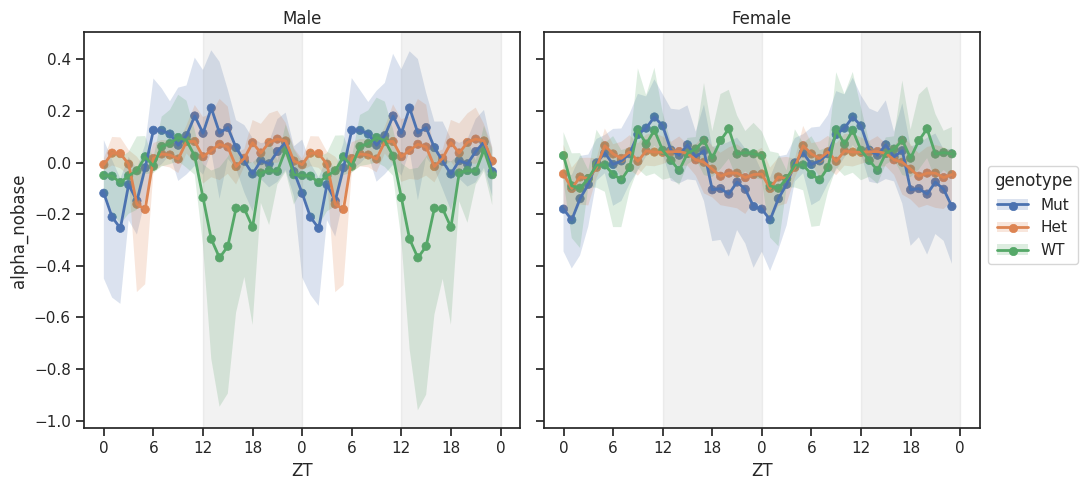

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


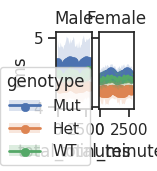

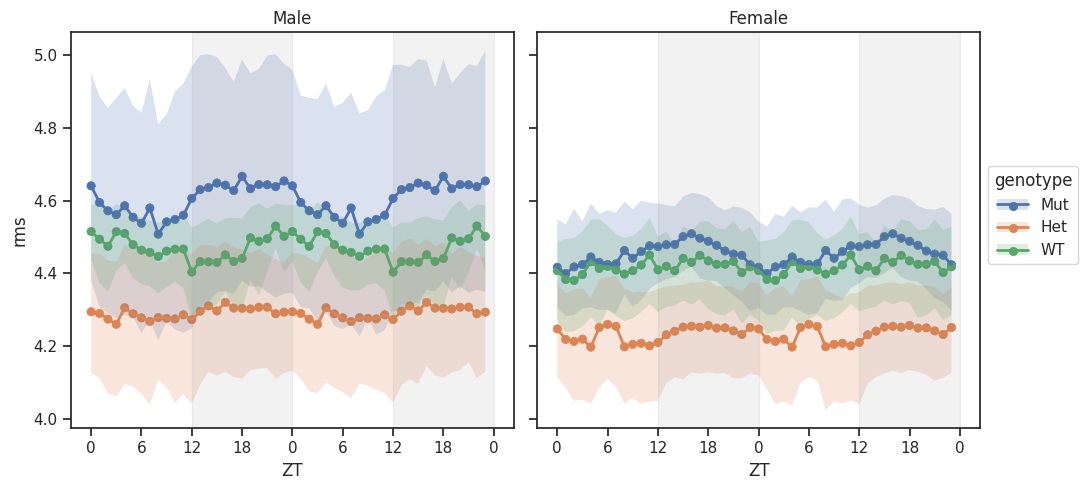

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


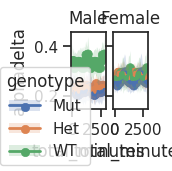

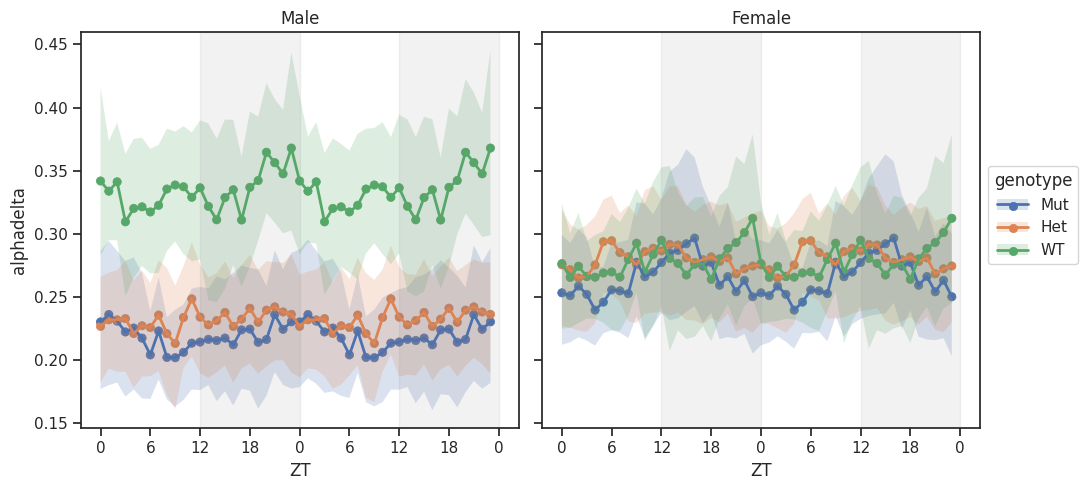

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


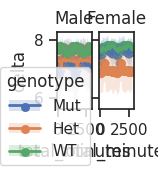

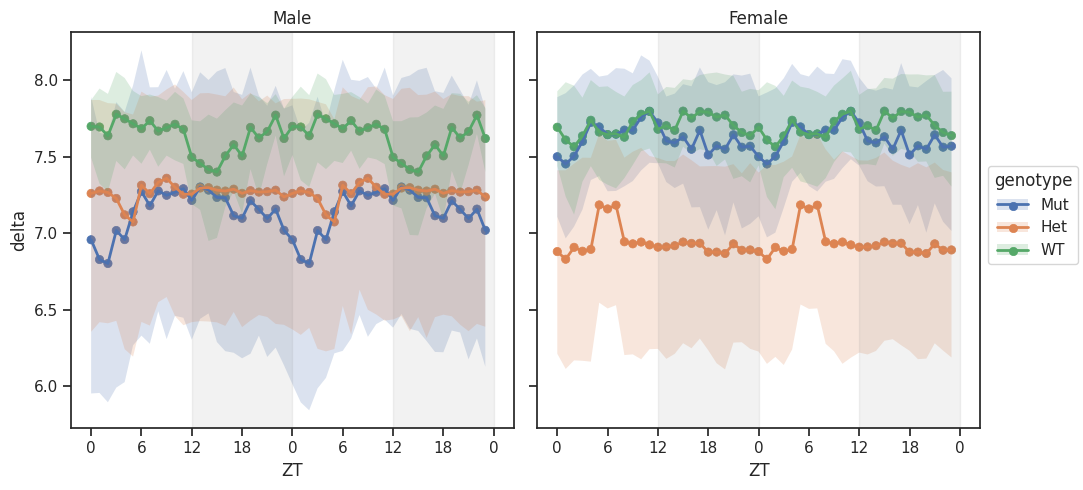

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


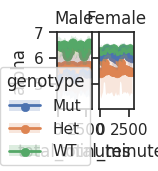

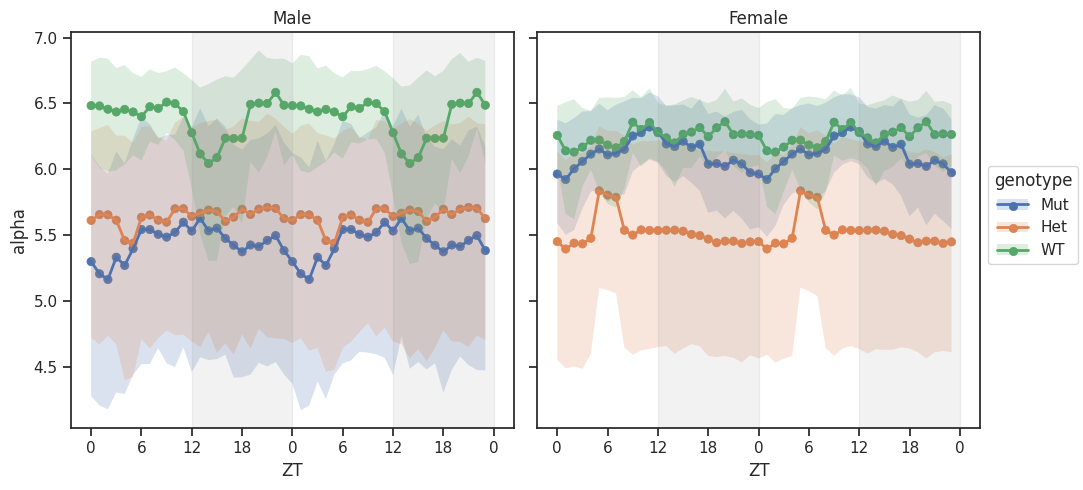

In [8]:
import matplotlib as mpl
for feature in ['rms_nobase', 'alphadelta_nobase', 'delta_nobase', 'alpha_nobase', 'rms', 'alphadelta', 'delta', 'alpha']:
    p = (  # fmt: off
        so.Plot(df, x="total_minutes", y=feature, color='genotype')  # fmt: off
        .facet(col='sex')
        # .add(so.Lines(linewidth=1, alpha=0.8), group='animal')
        .add(so.Line(linewidth=2), so.Agg())
        .add(so.Dot(), so.Agg())
        .add(so.Band(), so.Est())
        .layout(size=(1, 1))
        .theme(axes_style("ticks"))
    )
    fig = mpl.figure.Figure(figsize=(10, 5))
    p.show()
    p.on(fig).plot()
    for ax in fig.axes:
        # ax.axvspan(xmin=0, xmax=6 * 60, alpha=0.1, color='grey')
        ax.axvspan(xmin=12 * 60, xmax=24 * 60, alpha=0.1, color='grey')
        ax.axvspan(xmin=36 * 60, xmax=48 * 60, alpha=0.1, color='grey')

        # Set ticks every 12 hours (12 * 60 minutes)
        ax.set_xticks(np.arange(0, 49 * 60, 6 * 60))
        new_labels = [(x/60) % 24 for x in ax.get_xticks()]
        ax.set_xticklabels([f"{x:.0f}" for x in new_labels])
        ax.set_xlabel("ZT")

    fig.tight_layout()
    display(fig)
    plt.close()
